In [39]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio
import random
from torch.utils.data import DataLoader, Subset, random_split
from sklearn.metrics import classification_report, precision_recall_fscore_support

import csv
import pandas as pd 
import matplotlib.pyplot as plt

import warnings
from tqdm import tqdm


SAMPLE_RATE = 16000 
DURATION = 1.0  
BATCH_SIZE = 64

EPOCHS = 25

warnings.filterwarnings('ignore')


device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Cihaz: {device}")


Cihaz: cuda


In [40]:
# Ben kaggle üzerinden indirdim.Dosya yolunu data\SpeechCommands\speech_commands_v0.02 olarak ayarladım.
# Veri setini test ve train olarak ayırma işlemi torchaudio tarafından otomatik yapılıyor.
train_dataset = torchaudio.datasets.SPEECHCOMMANDS(root="./data",url="speech_commands_v0.02", download=False, subset="training")
test_dataset = torchaudio.datasets.SPEECHCOMMANDS(root="./data", url="speech_commands_v0.02", download=False ,subset="testing")


In [41]:
labels = sorted(list(set(
    train_dataset.get_metadata(i)[2] for i in range(len(train_dataset))
)))

label_to_index = {label: i for i, label in enumerate(labels)}
index_to_label = {i: label for i, label in enumerate(labels)}
NUM_CLASSES = len(labels)

print(f"Etiketler: {labels}")
print(f"Etiket sayısı: {NUM_CLASSES}")


Etiketler: ['backward', 'bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'follow', 'forward', 'four', 'go', 'happy', 'house', 'learn', 'left', 'marvin', 'nine', 'no', 'off', 'on', 'one', 'right', 'seven', 'sheila', 'six', 'stop', 'three', 'tree', 'two', 'up', 'visual', 'wow', 'yes', 'zero']
Etiket sayısı: 35


In [42]:
# Pytorch DataLoader için custom collate_fn fonksiyonu
# Pytorch DataLoader, farklı uzunluktaki ses dalga formlarını tek bir batch'te birleştiremez
# Bu nedenle özel bir collate_fn fonksiyonu tanımlıyoruz
# Uzun olan kısımları keser, eksi olan kısımları ise sıfır ile doldurur
# Bu sayede modelimize sabit boyutta giriş sağlanır

def collate_fn(batch):
    waveforms , targets = [] , []
    for waveform, _, label, _, _ in batch:
        target_len = int(SAMPLE_RATE * DURATION)
        if waveform.shape[1] > target_len:
            waveform = waveform[:, :target_len]
        elif waveform.shape[1] < target_len:
            padding_needed = target_len - waveform.shape[1]
            padding = torch.zeros((1, padding_needed))
            waveform = torch.cat([waveform, padding], dim=1)
        waveforms.append(waveform)
        targets.append(label_to_index[label])
    waveforms = torch.stack(waveforms).to(device)
    targets = torch.tensor(targets, dtype=torch.long).to(device)
    return waveforms, targets

In [ ]:
# CNN Modeli

class Cnn(nn.Module):
    def __init__(self,num_classes):
        super(Cnn, self).__init__()

        #n_mels 64, 128 
        #n_fft 1024, 512,
        #hop_length 512, 256 

        #512/16=32 ms, 256/16=16 ms
        #1. Resim 0-32 ms
        #2. Resim 16-48 ms
        self.mel_spectrogram = torchaudio.transforms.MelSpectrogram(
            sample_rate=16000,
            n_mels=64,
            n_fft=512,
            hop_length=256
        ).to(device)
        
        self.amplitude_to_db = torchaudio.transforms.AmplitudeToDB().to(device)
        
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.pool1 = nn.MaxPool2d(2)

        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool2 = nn.MaxPool2d(2)

        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.pool3 = nn.MaxPool2d(2)

        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        self.pool4 = nn.MaxPool2d(2)

        self.gap = nn.AdaptiveAvgPool2d((1, 1))

        self.fc1 = nn.Linear(128, num_classes)

        self.dropout = nn.Dropout(0.2) 
    
    def forward(self, x):
        x = self.mel_spectrogram(x)
        x = self.amplitude_to_db(x)

        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))
        x = self.pool4(F.relu(self.bn4(self.conv4(x))))
        
        
        x = self.gap(x) 
        x = torch.flatten(x, 1)

        x = self.dropout(x)

        x = self.fc1(x)
        
        return x

In [50]:
def train_model(model, train_loader, criterion, optimizer):
    model.train()
    total_loss = 0.0
    correct = 0
    total_samples = 0



    for data,target in tqdm(train_loader,desc="Training"):
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()


        total_loss += loss.item()
        predicted = torch.argmax(outputs, dim=1)
        correct += (predicted == target).sum().item()
        total_samples += len(data)

    avg_loss = total_loss / len(train_loader) 
    acc = 100.0 * correct / total_samples
    return avg_loss, acc

    
def validate_model(model, val_loader, criterion):
    model.eval()
    total_loss = 0.0
    correct = 0
    total_samples = 0
    with torch.no_grad():
        for data,target in tqdm(val_loader,desc="Validating"):
            outputs = model(data)
            loss = criterion(outputs, target)
            total_loss += loss.item()
            predicted = torch.argmax(outputs, dim=1)
            correct += (predicted == target).sum().item()
            total_samples += len(data)

    avg_loss = total_loss / len(val_loader)
    acc= 100.0 * correct / total_samples
    
    return avg_loss,acc
    


In [52]:
train_len = int(0.8 * len(train_dataset))
val_len = len(train_dataset) - train_len

train_subset, val_subset = random_split(train_dataset, [train_len, val_len])

train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

model = Cnn(NUM_CLASSES).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()


metrics= {
    "epoch": [],
    "train_loss": [],
    "train_acc": [],
    "val_loss": [],
    "val_acc": []
}

In [ ]:

best_model_acc = 0.0

    
for epoch in range(EPOCHS):


    train_loss, train_acc = train_model(model, train_loader,criterion,optimizer)

    val_loss, val_acc = validate_model(model, val_loader, criterion)

    metrics["epoch"].append(epoch + 1)
    metrics["train_loss"].append(train_loss)
    metrics["train_acc"].append(train_acc)
    metrics["val_loss"].append(val_loss)
    metrics["val_acc"].append(val_acc)

    learning_rate = optimizer.param_groups[0]['lr']

    print(f"Epoch {epoch+1}/{EPOCHS},Train Loss: {train_loss:.4f},Train Accuracy: {train_acc:.4f},Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")
    
    
    df = pd.DataFrame(metrics)
    df.to_csv("model_metrics.csv", index=False)
    
    if val_acc > best_model_acc:
        best_model_acc = val_acc
        torch.save(model.state_dict(), "best_model.pth")

        



In [54]:

def test(model,test_loader,criterion):
    model.eval()
    
    running_loss = 0.0
    correct = 0
    total = 0

    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    test_loss = running_loss / total
    test_acc = correct / total

    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')

    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")
    print(f"Test Precision: {precision:.4f}, Test Recall: {recall:.4f}, Test F1 Score: {f1:.4f}")

    try:
        all_labels = list(range(len(class_names)))
        report = classification_report(y_true, y_pred, target_names=class_names, labels=all_labels, zero_division=0)

        with open("test_report.txt", "w") as f:
            f.write(report)

    except Exception as e:
        print("Hata:", e)


class_names = [index_to_label[i] for i in range(NUM_CLASSES)]

model= Cnn(NUM_CLASSES).to(device)
model.load_state_dict(torch.load("best_model.pth"))

criterion = nn.CrossEntropyLoss()

test(model, test_loader, criterion)


100%|██████████| 172/172 [00:03<00:00, 45.79it/s]

Test Loss: 0.2387, Test Accuracy: 0.9362
Test Precision: 0.9378, Test Recall: 0.9362, Test F1 Score: 0.9362


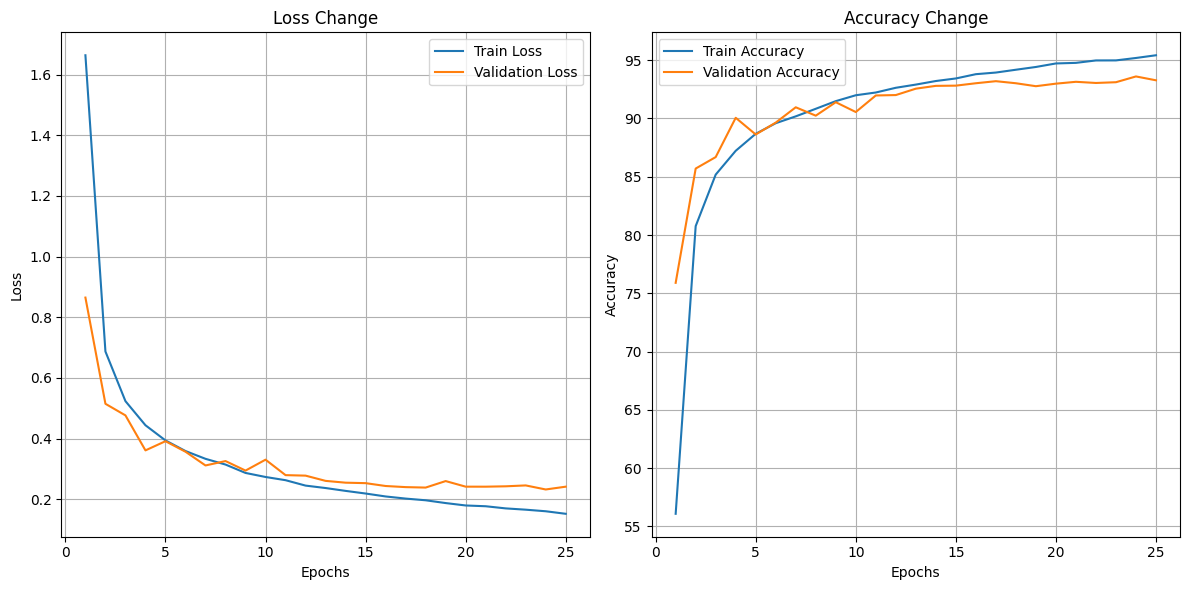

In [55]:
df = pd.read_csv("model_metrics.csv")

plt.figure(figsize=(12, 6))

plt.subplot(1,2,1)
plt.plot(df['epoch'], df['train_loss'], label='Train Loss')
plt.plot(df['epoch'], df['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Change')
plt.legend()
plt.grid(True)



plt.subplot(1,2,2)
plt.plot(df['epoch'], df['train_acc'], label='Train Accuracy')
plt.plot(df['epoch'], df['val_acc'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Change')
plt.legend()
plt.grid(True)
    

plt.tight_layout()

plt.show()
    